# Grafos explicados en clases

### Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Clase Grafo

In [ ]:
# Clase para representar un nodo en el grafo
class Node:
    def __init__(self, name):
        self.name = name

# Clase para representar un grafo
class Graph:

    def __init__(self, weighted=False, directed=False, use_matrix=False):
        self.weighted = weighted
        self.directed = directed
        self.use_matrix = use_matrix

        self.nodes = []
        self.node_indices = {}
        self.adjacency_list = {}

        self.matrix = []

    # Agrega un nodo al grafo si aun no existe
    def add_node(self, node):
        if node.name not in self.node_indices:
            # Registrar nodo
            self.node_indices[node.name] = len(self.nodes)
            self.nodes.append(node)

            # Lista de adyacencia
            if self.weighted:
                self.adjacency_list[node.name] = {}
            else:
                self.adjacency_list[node.name] = set()

            # Matriz
            default_value = float("inf") if self.weighted else 0
            for row in self.matrix:
                row.append(default_value)
            new_row = [default_value] * len(self.nodes)
            self.matrix.append(new_row)

            # Si es ponderado, la diagonal debe ser 0 (distancia a sí mismo)
            if self.weighted:
                idx = self.node_indices[node.name]
                self.matrix[idx][idx] = 0

    # Agrega una arista entre dos nodos
    def add_edge(self, node_a, node_b, weight=None):
        self.add_node(node_a)
        self.add_node(node_b)

        name_a = node_a.name
        name_b = node_b.name
        i = self.node_indices[name_a]
        j = self.node_indices[name_b]

        # Lista de adyacencia
        if self.weighted:
            self.adjacency_list[name_a][name_b] = weight
            if not self.directed:
                self.adjacency_list[name_b][name_a] = weight
        else:
            self.adjacency_list[name_a].add(name_b)
            if not self.directed:
                self.adjacency_list[name_b].add(name_a)

        # Matriz
        if self.weighted:
            self.matrix[i][j] = weight
            if not self.directed:
                self.matrix[j][i] = weight
        else:
            self.matrix[i][j] = 1
            if not self.directed:
                self.matrix[j][i] = 1

    # Carga nodos y aristas desde un archivo
    def load_from_file(self, filename):
        with open(filename, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 2:
                    continue

                node_a_name = parts[0]
                node_b_name = parts[1]
                weight = float(parts[2]) if self.weighted and len(parts) > 2 else None

                node_a = Node(node_a_name)
                node_b = Node(node_b_name)
                self.add_edge(node_a, node_b, weight)

    # Imprime la matriz de adyacencia de manera que la podamos leer
    def print_matrix(self):
        print("   ", "  ".join(n.name for n in self.nodes))
        for i, row in enumerate(self.matrix):
            formatted_row = [
                f"{v:.1f}" if isinstance(v, float) else str(v) for v in row
            ]
            print(f"{self.nodes[i].name} ", formatted_row)

    # Devuelve la lista de vecio
    def get_neighbors(self, node_name):
        if self.use_matrix:
            if node_name not in self.node_indices:
                return []
            index = self.node_indices[node_name]
            neighbors = []
            for j, value in enumerate(self.matrix[index]):
                if (self.weighted and value != float("inf") and index != j) or (not self.weighted and value != 0):
                    neighbor_name = self.nodes[j].name
                    weight = value if self.weighted else 1
                    neighbors.append((neighbor_name, weight))
            return neighbors
        else:
            if node_name not in self.adjacency_list:
                return []
            if self.weighted:
                return list(self.adjacency_list[node_name].items())  # [(vecino, peso), ...]
            else:
                return [(neighbor, 1) for neighbor in self.adjacency_list[node_name]]  # [(vecino, 1), ...]


    def get_node_names(self):
      if not self.use_matrix:
          return list(self.adjacency_list.keys())
      else:
          return [node.name for node in self.nodes]

#### Función Graficar Grafo

In [ ]:
def draw_graph(graph, camino=None, title="Grafo de Aeropuertos"):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Calcular posiciones en círculo
    nodes = list(graph.adjacency_list.keys())
    n = len(nodes)
    pos = {}
    for i, node in enumerate(nodes):
        angle = 2 * math.pi * i / n
        pos[node] = (math.cos(angle), math.sin(angle))

    # Dibujar aristas
    for origin in graph.adjacency_list:
        for dest, weight in graph.adjacency_list[origin].items():
            x1, y1 = pos[origin]
            x2, y2 = pos[dest]

            # Evitar duplicados en grafos no dirigidos
            if not graph.directed and origin > dest:
                continue

            # Dibujar línea
            line = plt.Line2D([x1, x2], [y1, y2], color='gray', alpha=0.5)
            ax.add_line(line)

            # Dibujar flecha si es dirigido
            if graph.directed:
                dx, dy = x2-x1, y2-y1
                ax.arrow(x1, y1, dx*0.9, dy*0.9,
                        head_width=0.03, head_length=0.05,
                        fc='gray', ec='gray', alpha=0.7)

            # Mostrar peso SOLO si el grafo es ponderado
            if graph.weighted:  # <-- Esta es la línea clave que cambiamos
                mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
                ax.text(mid_x, mid_y, f"{weight:.1f}",
                       color='darkblue', fontsize=8,
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    # Resto del código de visualización permanece igual...
    # Dibujar nodos
    for node in nodes:
        x, y = pos[node]
        color = 'orange' if camino and node in camino else 'lightblue'
        size = 1200 if camino and node in camino else 800
        ax.scatter(x, y, s=size, c=color, edgecolors='black')
        ax.text(x, y, node, ha='center', va='center', fontsize=10)

    # Resaltar camino
    if camino:
        for i in range(len(camino)-1):
            x1, y1 = pos[camino[i]]
            x2, y2 = pos[camino[i+1]]
            line = plt.Line2D([x1, x2], [y1, y2], color='red', linewidth=3)
            ax.add_line(line)

    ax.set_title(title)
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

### Representación de Grafos

Lista de Adyacencia

In [ ]:
g = Graph(weighted=False, directed=True, use_matrix=False)
g.load_from_file('Subset_airports.txt')
g.adjacency_list

{'ATL': {'BOS',
  'CLT',
  'DEN',
  'DFW',
  'DTW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'BOS': {'ATL',
  'CLT',
  'DEN',
  'DFW',
  'DTW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'CLT': {'ATL',
  'BOS',
  'DEN',
  'DFW',
  'DTW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'DEN': {'ATL',
  'BOS',
  'CLT',
  'DFW',
  'DTW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'OAK',
  'ORD',
  'PHL',
  'SFO'},
 'DFW': {'ATL',
  'BOS',
  'CLT',
  'DEN',
  'DTW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'DTW': {'ATL',
  'BOS',
  'CLT',
  'DEN',
  'DFW',
  'EWR',
  'IAD',
  'JFK',
  'LAX',
  'LGA',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'EWR': {'ATL',
  'BOS',
  'CLT',
  'DEN',
  'DFW',
  'DTW',
  'IAD',
  'LAX',
  'MIA',
  'ORD',
  'PHL',
  'SFO'},
 'IAD': {'ATL',
  'BOS',
  'CLT',
  'DEN',
  'DFW',
  'DTW',
  'EWR',
 

Lista de Adyacencia Ponderada

In [ ]:
g = Graph(weighted=True, directed=True, use_matrix=False)
g.load_from_file('Subset_airports.txt')
g.adjacency_list

{'ATL': {'BOS': 1.9664556962025315,
  'CLT': 3.969,
  'DEN': 4.28296875,
  'DFW': 2.4759398496240603,
  'DTW': 3.91504347826087,
  'EWR': 2.554237288135593,
  'IAD': 6.8837,
  'JFK': 3.8518518518518516,
  'LAX': 2.0279,
  'LGA': 1.5659712230215825,
  'MIA': 1.926283185840708,
  'ORD': 2.6666666666666665,
  'PHL': 2.869491525423729,
  'SFO': 1.5764797507788162},
 'BOS': {'ATL': 4.264912280701754,
  'CLT': 4.807248322147651,
  'DEN': 2.4738768115942027,
  'DFW': 6.634022556390978,
  'DTW': 3.385187969924812,
  'EWR': 2.244020618556701,
  'IAD': 5.814,
  'JFK': 17.90987341772152,
  'LAX': 1.58671875,
  'LGA': 6.501428571428572,
  'MIA': 2.0402415458937195,
  'ORD': 10.46913294797688,
  'PHL': 15.023763440860215,
  'SFO': 3.598585607940447},
 'CLT': {'ATL': 4.013595505617977,
  'BOS': 1.2581294964028777,
  'DEN': 0.8144635193133047,
  'DFW': 1.2153225806451613,
  'DTW': 3.6371171171171173,
  'EWR': 1.6208333333333333,
  'IAD': 2.6169230769230767,
  'JFK': 2.7061363636363636,
  'LAX': 1.355

Matriz Binaria

In [ ]:
g = Graph(weighted=False, directed=True, use_matrix=True)
g.load_from_file('Subset_airports.txt')
g.print_matrix()

    ATL  BOS  CLT  DEN  DFW  DTW  EWR  IAD  JFK  LAX  LGA  MIA  ORD  PHL  SFO  OAK
ATL  ['0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']
BOS  ['1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']
CLT  ['1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']
DEN  ['1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
DFW  ['1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']
DTW  ['1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']
EWR  ['1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '1', '1', '0']
IAD  ['1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '0']
JFK  ['1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '1', '0']
LAX  ['1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1']
LGA  ['1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '

Matriz Distancia

In [ ]:
g = Graph(weighted=True, directed=True, use_matrix=True)
g.load_from_file('Subset_airports.txt')
g.print_matrix()

    ATL  BOS  CLT  DEN  DFW  DTW  EWR  IAD  JFK  LAX  LGA  MIA  ORD  PHL  SFO  OAK
ATL  ['0', '2.0', '4.0', '4.3', '2.5', '3.9', '2.6', '6.9', '3.9', '2.0', '1.6', '1.9', '2.7', '2.9', '1.6', 'inf']
BOS  ['4.3', '0', '4.8', '2.5', '6.6', '3.4', '2.2', '5.8', '17.9', '1.6', '6.5', '2.0', '10.5', '15.0', '3.6', 'inf']
CLT  ['4.0', '1.3', '0', '0.8', '1.2', '3.6', '1.6', '2.6', '2.7', '1.4', '2.9', '1.6', '1.4', '4.4', '4.2', 'inf']
DEN  ['2.3', '1.0', '1.6', '0', '2.5', '1.4', '0.9', '1.2', '0.9', '1.8', '1.4', '1.6', '9.0', '2.2', '2.8', '0.6']
DFW  ['1.8', '0.9', '3.7', '1.3', '0', '1.8', '1.3', '1.4', '1.4', '2.6', '1.5', '1.5', '2.1', '2.2', '2.2', 'inf']
DTW  ['4.5', '3.1', '3.3', '1.6', '1.9', '0', '2.7', '2.5', '3.2', '1.9', '2.4', '1.4', '5.6', '5.3', '1.6', 'inf']
EWR  ['1.9', '1.5', '1.6', '0.6', '1.5', '2.5', '0', '11.0', 'inf', '2.1', 'inf', '3.5', '5.3', '5.1', '1.4', 'inf']
IAD  ['2.4', '0.8', '2.6', '1.1', '1.5', '1.5', '2.4', '0', '2.6', '1.2', '2.8', '1.2', '1.3', 'inf',

### Algoritmos BFS y UCS

Algoritmo BFS (Breadth First Search)

In [ ]:
def bfs(graph, start_name, goal_name):
    if start_name not in graph.get_node_names() or goal_name not in graph.get_node_names():
        return None

    visited = set()
    queue = [(start_name, [start_name])]

    while queue:
        current, path = queue.pop(0)

        if current == goal_name:
            return path

        if current not in visited:
            visited.add(current)

            for neighbor, _ in graph.get_neighbors(current):  # ← ahora correcto
                if neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

    return None

In [ ]:
def ucs(graph, start_name, goal_name):
    if start_name not in graph.get_node_names() or goal_name not in graph.get_node_names():
        return None

    frontier = [(0, start_name, [start_name])]
    explored = {}

    while frontier:
        frontier.sort(key=lambda x: x[0])
        cost, current, path = frontier.pop(0)

        if current == goal_name:
            return path, cost

        if current in explored and explored[current] <= cost:
            continue

        explored[current] = cost

        for neighbor, weight in graph.get_neighbors(current):
            new_cost = cost + weight
            new_path = path + [neighbor]

            if neighbor not in explored or new_cost < explored.get(neighbor, float('inf')):
                frontier.append((new_cost, neighbor, new_path))

    return None

In [ ]:
g = Graph(weighted=False, directed=True, use_matrix=False)
g.load_from_file("aeropuertos.txt")

camino = bfs(g, "JFK", "LAX")
print("Camino BFS:", camino)

Camino BFS: ['JFK', 'LAX']


In [ ]:
g = Graph(weighted=True, directed=True, use_matrix=False)
g.load_from_file("aeropuertos.txt")

camino_ucs = ucs(g, "JFK", "LAX")
if camino_ucs:
    print("Camino UCS:", " -> ".join(camino_ucs[0]), "Costo:", camino_ucs[1])
else:
    print("No se encontró un camino.")

Camino UCS: JFK -> LAX Costo: 320.0


### Optimizador de vuelos

#### Análisis del Dataset

In [ ]:
df=pd.read_csv('/content/Subset_airports.csv')

<Axes: title={'center': 'Es sin parada?'}, ylabel='count'>

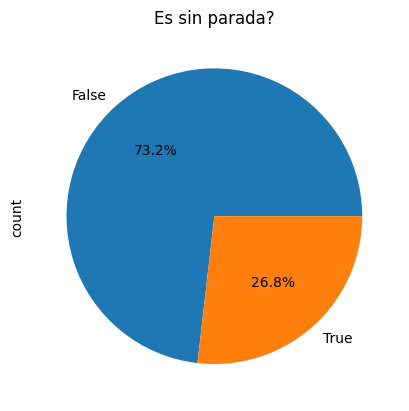

In [ ]:
#Distribucion de los tipos de vuelo
df['isNonStop'].value_counts().plot(kind='pie',title='Es sin parada?',autopct='%1.1f%%')

In [ ]:
#Extraemos solo los vuelos directos
a = df[df['isNonStop'] == True].reset_index(drop=True)

In [ ]:
#Extraemos solos los campos necesarios
a=a[['startingAirport','destinationAirport','segmentsDurationInSeconds','baseFare']]

In [ ]:
#Creando columna de conexiones
a['Conection']=a['startingAirport']+' '+a['destinationAirport']

In [ ]:
a['Conection'].value_counts()

,count
Conection,
ORD LGA,485
LGA ORD,484
JFK LAX,412
LAX JFK,388
LAX SFO,336
...,...
MIA IAD,20
DEN OAK,7
OAK DEN,7


<Axes: title={'center': 'Distribucion de aeropuertos de salida'}, xlabel='startingAirport'>

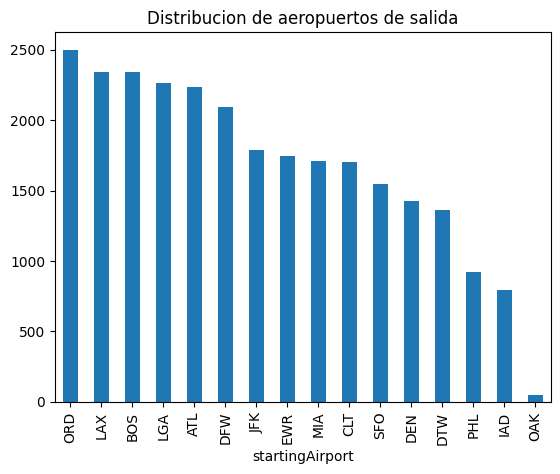

In [ ]:
#Distribucion de aeropuertos de salida
a['startingAirport'].value_counts().plot(kind='bar',title='Distribucion de aeropuertos de salida')

<Axes: title={'center': 'Distribucion de aeropuertos de llegada'}, xlabel='destinationAirport'>

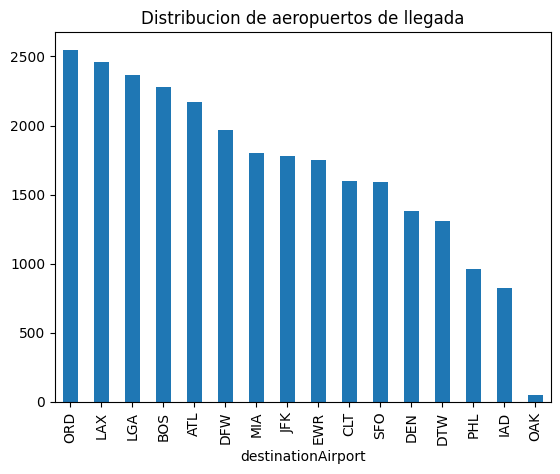

In [ ]:
a['destinationAirport'].value_counts().plot(kind='bar',title='Distribucion de aeropuertos de llegada')

<Axes: title={'center': 'Distribucion de precios'}, ylabel='Frequency'>

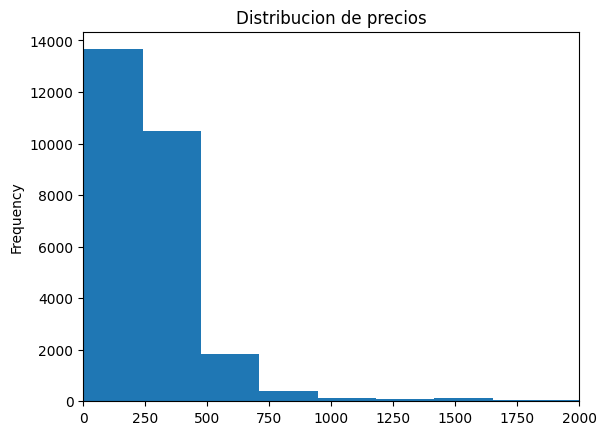

In [ ]:
a['baseFare'].plot(kind='hist',title='Distribucion de precios',bins=15,xlim=(0,2000))

##Analisis de los costos

In [ ]:
df[['searchDate','flightDate','startingAirport','destinationAirport','baseFare']].loc[1]

,1
searchDate,2022-04-16
flightDate,2022-04-17
startingAirport,ATL
destinationAirport,BOS
baseFare,217.67


###Vuelo con un dia de antelacion
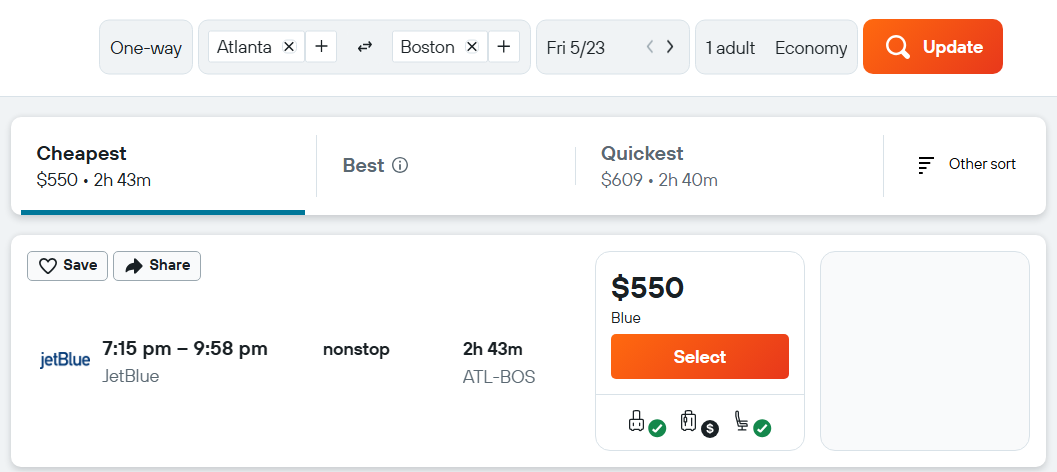

###Vuelo con 15 dias de antelacion
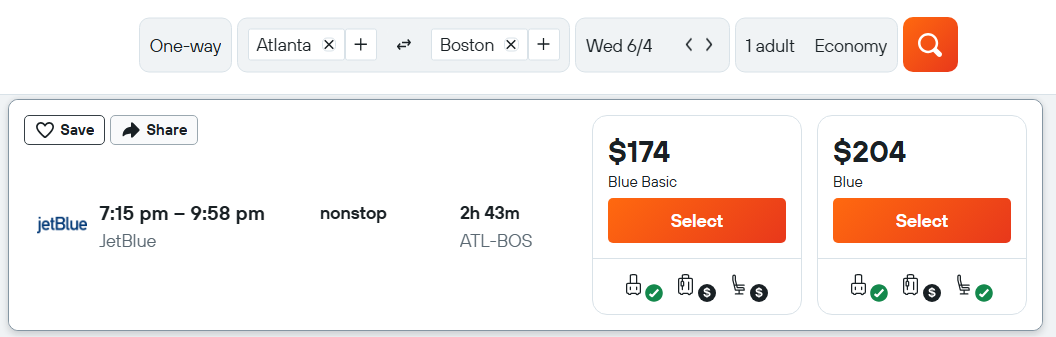

> *Vemos como los vuelos que se agendan con un tiempo de antelacion mas considerable tienen mejores tarifas. Eso explica porque alguno de los vuelos tienen precios algo elevados, a pesar de no ser tan largos en algunos casos*

##Convirtiendo dataset en txt

In [ ]:
grafo_combinado = Graph(directed=True,weighted=True)

for i in range(len(a)):
    grafo_combinado.add_edge(
        Node(a['startingAirport'][i]),
        Node(a['destinationAirport'][i]),
        weight=float(a['baseFare'][i])
    )

In [ ]:
with open("prueba.txt", "w") as file:
    for origin in grafo_combinado.adjacency_list:
        for destination, weight in grafo_combinado.adjacency_list[origin].items():
            file.write(f"{origin} {destination} {weight}\n")

## Interfaz

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Crear grafo
g = Graph(weighted=True, directed=False)
g.load_from_file("prueba.txt")

# Interfaz
origen_input = widgets.Text(description="Origen:", placeholder="Ej: ATL")
destino_input = widgets.Text(description="Destino:", placeholder="Ej: LAX")
algoritmo_dropdown = widgets.Dropdown(
    options=[('BFS', 'bfs'), ('UCS', 'ucs')],
    description='Algoritmo:'
)
boton_buscar = widgets.Button(description="Buscar camino")
salida = widgets.Output()

def on_button_click(b):
    with salida:
        clear_output()
        origen = origen_input.value.strip().upper()
        destino = destino_input.value.strip().upper()
        algoritmo = algoritmo_dropdown.value

        if not origen or not destino:
            print("❌ Ingrese ambos aeropuertos")
            return

        if origen not in g.adjacency_list:
            print(f"❌ Aeropuerto {origen} no existe")
            return

        if destino not in g.adjacency_list:
            print(f"❌ Aeropuerto {destino} no existe")
            return

        if algoritmo == 'bfs':
            print("🔍 Buscando con BFS...")
            camino = bfs(g, origen, destino)
            if camino:
                print(f"✅ Camino encontrado: {' → '.join(camino)}")
                draw_graph(g, camino, "Resultado BFS")
            else:
                print("❌ No se encontró camino con BFS")
        else:
            print("🔍 Buscando con UCS...")
            resultado = ucs(g, origen, destino)
            if resultado:
                camino, costo = resultado
                print(f"✅ Camino encontrado: {' → '.join(camino)}")
                print(f"💰 Costo total: {costo:.2f}")
                draw_graph(g, camino, f"Resultado UCS (Costo: {costo:.2f})")
            else:
                print("❌ No se encontró camino con UCS")

boton_buscar.on_click(on_button_click)
display(origen_input, destino_input, algoritmo_dropdown, boton_buscar, salida)


Text(value='', description='Origen:', placeholder='Ej: ATL')

Text(value='', description='Destino:', placeholder='Ej: LAX')

Dropdown(description='Algoritmo:', options=(('BFS', 'bfs'), ('UCS', 'ucs')), value='bfs')

Button(description='Buscar camino', style=ButtonStyle())

Output()